In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'KR Variation 6 LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## The Kroger Co. Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.68750,9.252111,-93.750000,-7835000.0,2.0
2000-01-24,8.40625,9.121979,-96.428571,-15986000.0,2.0
2000-01-25,8.15625,8.973405,-93.939394,-27586200.0,1.0
2000-01-26,8.06250,8.833266,-92.857143,-35302800.0,2.0
2000-01-27,8.25000,8.743533,-83.076923,-22065800.0,2.0


In [6]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [7]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [8]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [9]:
from collections import Counter

Counter(y)

Counter({2.0: 4315, 1.0: 215, 0.0: 215})

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [11]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [12]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 33ms/step - loss: 0.2969 - accuracy: 0.4795 - mse: 0.4523 - weighted_accuracy: 0.3046 - weighted_mse: 0.5232 - val_loss: 0.2996 - val_accuracy: 0.0464 - val_mse: 0.3554 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3554
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2095 - accuracy: 0.3396 - mse: 0.7919 - weighted_accuracy: 0.4614 - weighted_mse: 0.7708 - val_loss: 0.2896 - val_accuracy: 0.0453 - val_mse: 0.3874 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3874
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1899 - accuracy: 0.3127 - mse: 1.0306 - weighted_accuracy: 0.4847 - weighted_mse: 1.0053 - val_loss: 0.2794 - val_accuracy: 0.0453 - val_mse: 0.4303 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4303
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.2871 - mse: 1.1575 - weighted_accuracy: 0.5104 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1370 - accuracy: 0.4049 - mse: 1.6000 - weighted_accuracy: 0.7229 - weighted_mse: 1.5140 - val_loss: 0.1875 - val_accuracy: 0.3435 - val_mse: 1.5997 - val_weighted_accuracy: 0.3435 - val_weighted_mse: 1.5997
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1365 - accuracy: 0.4096 - mse: 1.6061 - weighted_accuracy: 0.7192 - weighted_mse: 1.5160 - val_loss: 0.1936 - val_accuracy: 0.3267 - val_mse: 1.6861 - val_weighted_accuracy: 0.3267 - val_weighted_mse: 1.6861
Epoch 32/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1353 - accuracy: 0.4178 - mse: 1.6185 - weighted_accuracy: 0.7129 - weighted_mse: 1.5259 - val_loss: 0.2041 - val_accuracy: 0.2866 - val_mse: 1.6487 - val_weighted_accuracy: 0.2866 - val_weighted_mse: 1.6487
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1351 - accuracy: 0.4307 - mse: 1.6237 - weighted_accuracy: 0.7158 - weig

Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1098 - accuracy: 0.5782 - mse: 2.0994 - weighted_accuracy: 0.8159 - weighted_mse: 2.0498 - val_loss: 0.1856 - val_accuracy: 0.4636 - val_mse: 2.1858 - val_weighted_accuracy: 0.4636 - val_weighted_mse: 2.1858
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1103 - accuracy: 0.5840 - mse: 2.1138 - weighted_accuracy: 0.8144 - weighted_mse: 2.0712 - val_loss: 0.1993 - val_accuracy: 0.4247 - val_mse: 2.2082 - val_weighted_accuracy: 0.4247 - val_weighted_mse: 2.2082
Epoch 61/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1078 - accuracy: 0.5948 - mse: 2.1305 - weighted_accuracy: 0.8275 - weighted_mse: 2.0861 - val_loss: 0.1880 - val_accuracy: 0.4700 - val_mse: 2.2289 - val_weighted_accuracy: 0.4700 - val_weighted_mse: 2.2289
Epoch 62/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1070 - accuracy: 0.5748 - mse: 2.1658 - weighted_accuracy: 0.8184 - 

Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0851 - accuracy: 0.7176 - mse: 2.8782 - weighted_accuracy: 0.8836 - weighted_mse: 2.9062 - val_loss: 0.1749 - val_accuracy: 0.5680 - val_mse: 2.9957 - val_weighted_accuracy: 0.5680 - val_weighted_mse: 2.9957
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0835 - accuracy: 0.7079 - mse: 2.8810 - weighted_accuracy: 0.8763 - weighted_mse: 2.9126 - val_loss: 0.1796 - val_accuracy: 0.5564 - val_mse: 3.1081 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 3.1081
Epoch 90/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0841 - accuracy: 0.7255 - mse: 2.8938 - weighted_accuracy: 0.8791 - weighted_mse: 2.9283 - val_loss: 0.1792 - val_accuracy: 0.5606 - val_mse: 3.1887 - val_weighted_accuracy: 0.5606 - val_weighted_mse: 3.1887
Epoch 91/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0840 - accuracy: 0.7044 - mse: 2.9181 - weighted_accuracy: 0.8769 - 

Epoch 117/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0675 - accuracy: 0.7879 - mse: 3.9219 - weighted_accuracy: 0.9186 - weighted_mse: 3.9491 - val_loss: 0.1705 - val_accuracy: 0.6660 - val_mse: 4.1924 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 4.1924
Epoch 118/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0663 - accuracy: 0.7919 - mse: 3.8738 - weighted_accuracy: 0.9145 - weighted_mse: 3.8886 - val_loss: 0.1724 - val_accuracy: 0.6828 - val_mse: 4.4981 - val_weighted_accuracy: 0.6828 - val_weighted_mse: 4.4981
Epoch 119/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0643 - accuracy: 0.7982 - mse: 3.9699 - weighted_accuracy: 0.9224 - weighted_mse: 3.9742 - val_loss: 0.1768 - val_accuracy: 0.6259 - val_mse: 3.8892 - val_weighted_accuracy: 0.6259 - val_weighted_mse: 3.8892
Epoch 120/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0655 - accuracy: 0.7956 - mse: 4.0115 - weighted_accuracy: 0.915

Epoch 146/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0521 - accuracy: 0.8483 - mse: 5.2093 - weighted_accuracy: 0.9315 - weighted_mse: 5.1570 - val_loss: 0.1903 - val_accuracy: 0.6839 - val_mse: 5.0747 - val_weighted_accuracy: 0.6839 - val_weighted_mse: 5.0747
Epoch 147/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0508 - accuracy: 0.8556 - mse: 5.3018 - weighted_accuracy: 0.9434 - weighted_mse: 5.2163 - val_loss: 0.1734 - val_accuracy: 0.7187 - val_mse: 5.6439 - val_weighted_accuracy: 0.7187 - val_weighted_mse: 5.6439
Epoch 148/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0498 - accuracy: 0.8635 - mse: 5.3842 - weighted_accuracy: 0.9463 - weighted_mse: 5.2974 - val_loss: 0.1774 - val_accuracy: 0.7007 - val_mse: 5.5367 - val_weighted_accuracy: 0.7007 - val_weighted_mse: 5.5367
Epoch 149/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0496 - accuracy: 0.8546 - mse: 5.4200 - weighted_accuracy: 0.939

Epoch 175/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0380 - accuracy: 0.9028 - mse: 7.1809 - weighted_accuracy: 0.9625 - weighted_mse: 6.7802 - val_loss: 0.2003 - val_accuracy: 0.7092 - val_mse: 7.0226 - val_weighted_accuracy: 0.7092 - val_weighted_mse: 7.0226
Epoch 176/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0392 - accuracy: 0.8933 - mse: 7.0304 - weighted_accuracy: 0.9554 - weighted_mse: 6.6589 - val_loss: 0.2002 - val_accuracy: 0.7482 - val_mse: 7.7169 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 7.7169
Epoch 177/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0385 - accuracy: 0.8865 - mse: 7.1116 - weighted_accuracy: 0.9584 - weighted_mse: 6.7523 - val_loss: 0.1990 - val_accuracy: 0.7629 - val_mse: 7.9125 - val_weighted_accuracy: 0.7629 - val_weighted_mse: 7.9125
Epoch 178/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0378 - accuracy: 0.8938 - mse: 7.1974 - weighted_accuracy: 0.955

In [16]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20987866818904877
Test accuracy: 0.7881981134414673


In [17]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-5.620653   -3.2218814   2.670052  ]
 [-3.9090755  -1.0937408   0.38011554]
 [-1.8633906  -7.1729145   1.1071627 ]
 ...
 [-2.9625633  -1.4758631   0.03034554]
 [-1.64072    -2.3879175   0.41819462]
 [-0.7043259  -6.1369686   0.59289664]]


Counter({2: 832, 1: 43, 0: 74})

In [18]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [19]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 42
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 42
actual holds but predicted buy: 42
actual holds but predicted sell: 73
actual predicted holds: 748
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 86.67439165701043%
actual buys: 43
actual sells: 43
actual holds: 863


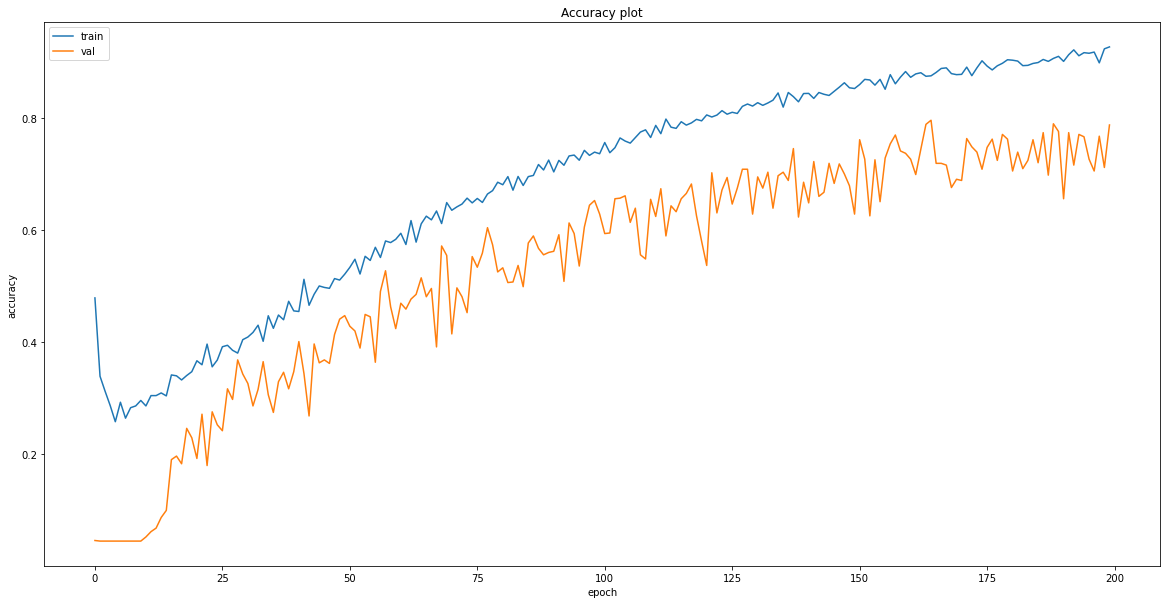

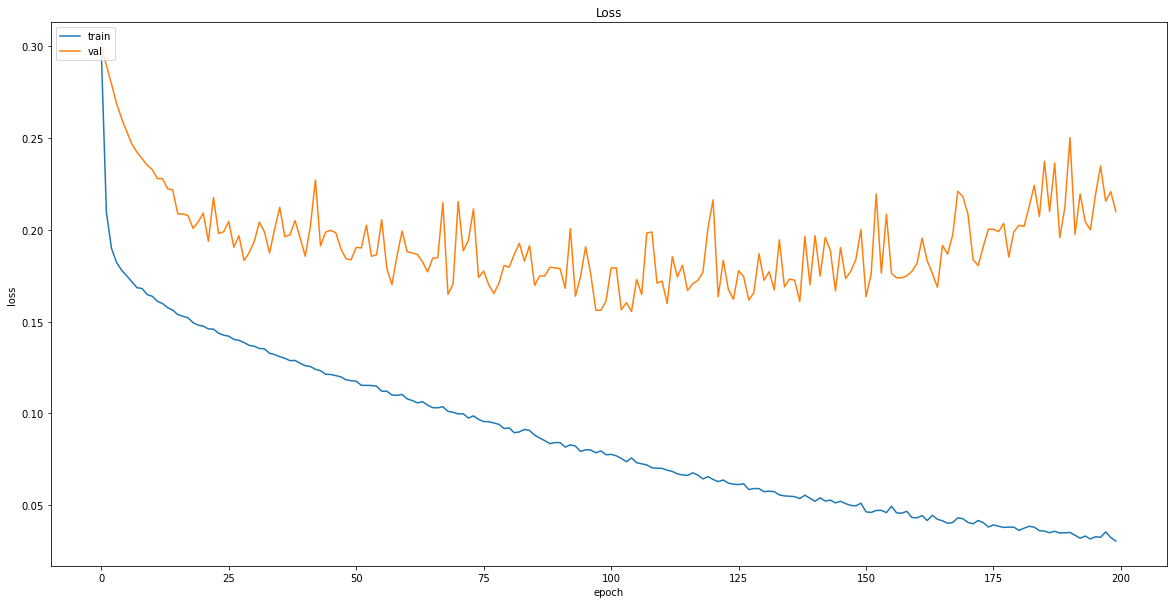

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# Save model
model.save("models/{}".format('KR_no_support_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/KR_no_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [22]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [23]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,29.430000,28.387007,-4.858258,41061300.0,2.0
2019-01-23,29.320000,28.530544,-9.311725,36484100.0,2.0
2019-01-24,29.240000,28.639691,-14.919380,31104500.0,2.0
2019-01-25,28.709999,28.650508,-38.135648,21525300.0,2.0
2019-01-28,28.120001,28.568891,-63.135567,13527400.0,2.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/KR_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.2160 - accuracy: 0.7569 - mean_squared_error: 9.6636 - weighted_accuracy: 0.7569 - weighted_mean_squared_error: 9.6636
Test loss: 0.21596898138523102
Test accuracy: 0.7568807601928711


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 0: 16, 1: 21})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 199, 0: 9})

In [30]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)

In [31]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,27.830000,28.291108,-76.063803,22475300.0,2.0,2,1
2019-02-11,27.549999,28.220168,-89.447281,18063500.0,1.0,2,2
2019-02-12,28.580000,28.117065,-98.564652,13001800.0,2.0,2,2
2019-02-13,28.959999,28.188286,-45.077757,21452700.0,2.0,2,2
2019-02-14,28.959999,28.307011,-7.096817,27986100.0,2.0,0,2


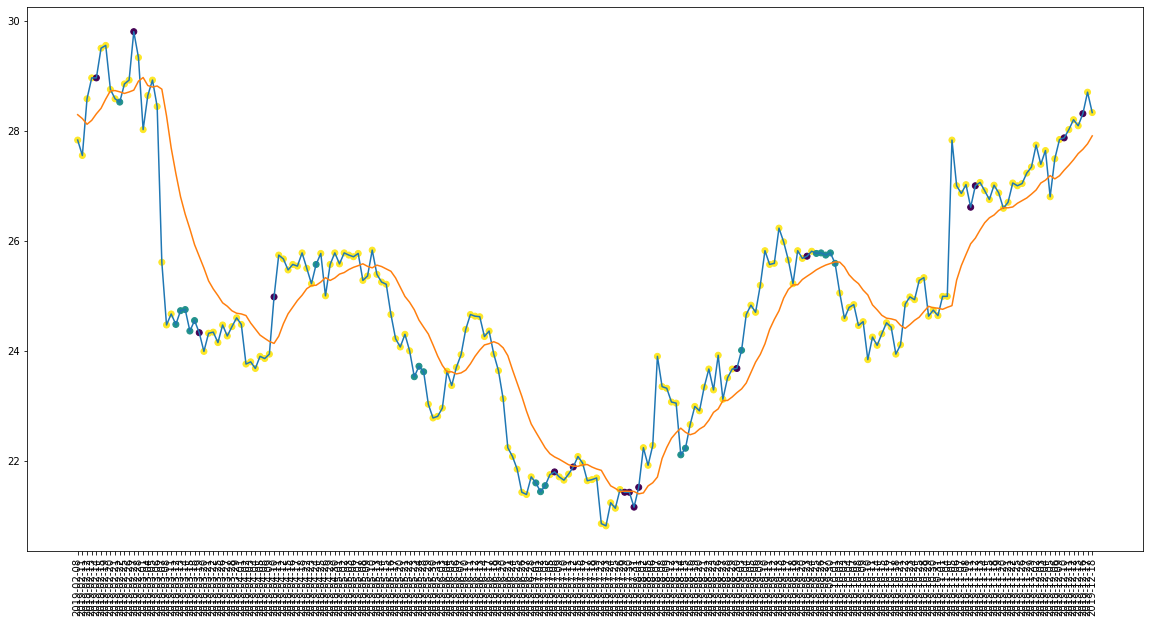

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 14
actual predicted holds: 164
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 82.41206030150754%
actual buys: 10
actual sells: 9
actual holds: 199


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[27.54999923706055, 27.82999992370605, 28.57999992370605, 28.57999992370605, 28.75, 28.959999084472656, 28.959999084472656, 29.5, 29.54999923706055]
[28.020000457763672, 28.520000457763672, 28.57999992370605, 28.75, 28.85000038146973, 28.920000076293945, 29.32999992370605, 29.54999923706055, 29.79999923706055]
Percentage buys correct: 38.095238095238095%
Percentage sells correct: 43.75%
Percentage holds correct: 82.32044198895028%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.520000457763672
Shares owned at the moment: 349
Cash capital at the moment: $19.147769801140385


Stop Loss Activated!

Share price: $25.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8932.458784728049


Share price: $24.479999542236328
Shares owned at the moment: 363
Cash capital at the moment: $21.781791353223525


Stop Loss Activated!

Share price: $23.76000022888184
Shares owned at the moment: 0
Cash capital at the moment: $8622.943454208851


Share price: $25.56999969482422
Shares owned at the moment: 336
Cash capital at the moment: $7.796877029895768


Stop Loss Activated!

Share price: $24.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $8270.770985901356


Share price: $23.53000068664551
Shares owned at the moment: 350
Cash capital at the moment: $12.623119914529525


Stop Loss Activated!

Share price: $22.78000068664551
Shares owned at the moment: 0
Cash capital at the moment: $7963.697609579562


Share price

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10123.710480150223
profit gained: 1.237104801502228%


In [37]:
logger

[0.7568807601928711,
 '0.0%',
 '11.11111111111111%',
 '82.41206030150754%',
 '38.095238095238095%',
 '43.75%',
 '82.32044198895028%',
 '-16.087911087532067%',
 '1.237104801502228%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,0.0%,11.11111111111111%,82.41206030150754%,38.095238095238095%,43.75%,82.32044198895028%,-16.087911087532067%,1.237104801502228%


### Recession Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/KR_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1997 - accuracy: 0.7900 - mean_squared_error: 8.8860 - weighted_accuracy: 0.7900 - weighted_mean_squared_error: 8.8860
Test loss: 0.19969429075717926
Test accuracy: 0.7899543642997742


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 20, 1: 9})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,28.139999,27.846915,-35.078541,6047600.0,2.0,2,2
2020-02-11,28.440001,27.892005,-25.654440,10558800.0,2.0,2,2
2020-02-12,28.690001,27.976312,-9.473693,14655000.0,2.0,2,2
2020-02-13,28.629999,28.086110,-7.075451,19030600.0,2.0,2,2
2020-02-14,28.230000,28.169785,-9.905703,15348600.0,2.0,2,2


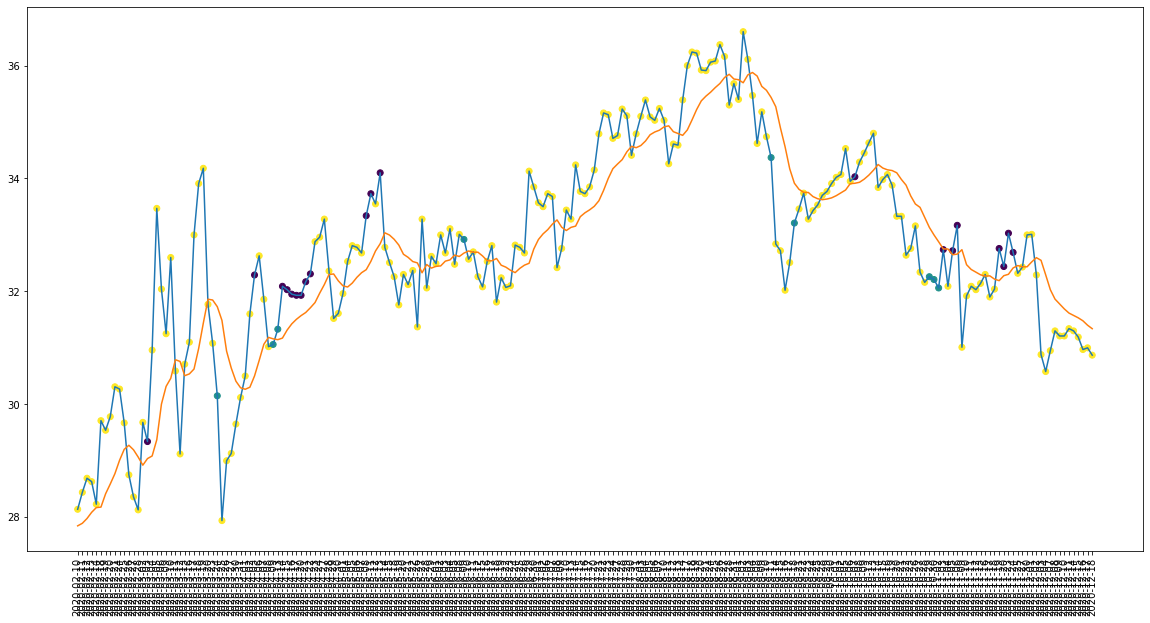

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 10
actual holds but predicted buy: 8
actual holds but predicted sell: 16
actual predicted holds: 169
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 23.076923076923077%
Percentage holds correct: 87.56476683937824%
actual buys: 13
actual sells: 13
actual holds: 193


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[28.13999938964844, 28.229999542236328, 28.440000534057607, 28.6299991607666, 28.690000534057607, 29.540000915527344, 29.709999084472656, 29.78000068664551, 30.309999465942386]
[28.1299991607666, 28.36000061035156, 28.75, 29.540000915527344, 29.670000076293945, 29.68000030517578, 29.78000068664551, 30.270000457763672, 30.309999465942386]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 60.0%
Percentage holds correct: 79.47368421052632%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.149999618530273
Shares owned at the moment: 330
Cash capital at the moment: $23.139001231193106


Stop Loss Activated!

Share price: $27.940000534057607
Shares owned at the moment: 0
Cash capital at the moment: $9217.983626985546


Share price: $31.059999465942386
Shares owned at the moment: 295
Cash capital at the moment: $30.086359965795054


Price increase from previously bought: 7.046256169162346%
Share price: $33.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9838.339329855435


Share price: $32.919998168945305
Shares owned at the moment: 298
Cash capital at the moment: $1.2019370102825633


Stop Loss Activated!

Share price: $31.809999465942386
Shares owned at the moment: 0
Cash capital at the moment: $9454.513483298775


Share price: $34.36999893188477
Shares owned at the moment: 274
Cash capital at the moment: $11.235981767171324


Stop Loss Activated!

Share price: $32.84000015258789
Shares owned at the moment: 0
Cash capital at the 

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10908.974277930256
profit gained: 9.08974277930256%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,0.0%,11.11111111111111%,82.41206030150754%,38.095238095238095%,43.75%,82.32044198895028%,-16.087911087532067%,1.237104801502228%
1,0.789954,7.6923076923076925%,23.076923076923077%,87.56476683937824%,44.44444444444444%,60.0%,79.47368421052632%,-17.263616551914257%,9.08974277930256%


### with WMT stock price

In [55]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.68750,9.252111,-93.750000,-7835000.0,2.0
2000-01-24,8.40625,9.121979,-96.428571,-15986000.0,2.0
2000-01-25,8.15625,8.973405,-93.939394,-27586200.0,1.0
2000-01-26,8.06250,8.833266,-92.857143,-35302800.0,2.0
2000-01-27,8.25000,8.743533,-83.076923,-22065800.0,2.0


In [56]:
df2 = pd.read_csv("data/variation 6/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [57]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2000-01-21,8.68750,9.252111,-93.750000,-7835000.0,63.3750,2.0
2000-01-24,8.40625,9.121979,-96.428571,-15986000.0,62.4375,2.0
2000-01-25,8.15625,8.973405,-93.939394,-27586200.0,59.3750,1.0
2000-01-26,8.06250,8.833266,-92.857143,-35302800.0,61.1250,2.0
2000-01-27,8.25000,8.743533,-83.076923,-22065800.0,61.9375,2.0


In [58]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [59]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(4745, 15, 5)

In [60]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [61]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 33ms/step - loss: 0.3044 - accuracy: 0.5282 - mse: 0.4331 - weighted_accuracy: 0.3041 - weighted_mse: 0.5223 - val_loss: 0.3017 - val_accuracy: 0.0443 - val_mse: 0.3545 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3545
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2157 - accuracy: 0.3541 - mse: 0.7516 - weighted_accuracy: 0.4078 - weighted_mse: 0.7444 - val_loss: 0.2924 - val_accuracy: 0.0453 - val_mse: 0.3844 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3844
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.2792 - mse: 0.9990 - weighted_accuracy: 0.4762 - weighted_mse: 0.9705 - val_loss: 0.2810 - val_accuracy: 0.0453 - val_mse: 0.4215 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4215
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1834 - accuracy: 0.2698 - mse: 1.1424 - weighted_accuracy: 0.4966 - weighte

Epoch 30/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1301 - accuracy: 0.4484 - mse: 1.6013 - weighted_accuracy: 0.7481 - weighted_mse: 1.5288 - val_loss: 0.1913 - val_accuracy: 0.3741 - val_mse: 1.6459 - val_weighted_accuracy: 0.3741 - val_weighted_mse: 1.6459
Epoch 31/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1300 - accuracy: 0.4555 - mse: 1.6178 - weighted_accuracy: 0.7544 - weighted_mse: 1.5383 - val_loss: 0.2001 - val_accuracy: 0.3446 - val_mse: 1.7459 - val_weighted_accuracy: 0.3446 - val_weighted_mse: 1.7459
Epoch 32/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1277 - accuracy: 0.4734 - mse: 1.6279 - weighted_accuracy: 0.7517 - weighted_mse: 1.5490 - val_loss: 0.2090 - val_accuracy: 0.2972 - val_mse: 1.6840 - val_weighted_accuracy: 0.2972 - val_weighted_mse: 1.6840
Epoch 33/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1267 - accuracy: 0.4995 - mse: 1.6209 - weighted_accuracy: 0.7742 - 

Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0942 - accuracy: 0.6733 - mse: 2.2798 - weighted_accuracy: 0.8563 - weighted_mse: 2.3049 - val_loss: 0.1653 - val_accuracy: 0.5996 - val_mse: 2.3682 - val_weighted_accuracy: 0.5996 - val_weighted_mse: 2.3682
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0931 - accuracy: 0.6934 - mse: 2.2914 - weighted_accuracy: 0.8784 - weighted_mse: 2.3278 - val_loss: 0.1963 - val_accuracy: 0.4900 - val_mse: 2.3253 - val_weighted_accuracy: 0.4900 - val_weighted_mse: 2.3253
Epoch 61/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0911 - accuracy: 0.6878 - mse: 2.3198 - weighted_accuracy: 0.8745 - weighted_mse: 2.3483 - val_loss: 0.1702 - val_accuracy: 0.5901 - val_mse: 2.4282 - val_weighted_accuracy: 0.5901 - val_weighted_mse: 2.4282
Epoch 62/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0892 - accuracy: 0.6905 - mse: 2.3638 - weighted_accuracy: 0.8792 - 

Epoch 88/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0617 - accuracy: 0.8282 - mse: 3.6365 - weighted_accuracy: 0.9352 - weighted_mse: 3.7715 - val_loss: 0.1887 - val_accuracy: 0.6185 - val_mse: 3.7490 - val_weighted_accuracy: 0.6185 - val_weighted_mse: 3.7490
Epoch 89/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0605 - accuracy: 0.8135 - mse: 3.6717 - weighted_accuracy: 0.9280 - weighted_mse: 3.8174 - val_loss: 0.1756 - val_accuracy: 0.6596 - val_mse: 3.8100 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 3.8100
Epoch 90/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0602 - accuracy: 0.8269 - mse: 3.7204 - weighted_accuracy: 0.9310 - weighted_mse: 3.8713 - val_loss: 0.1738 - val_accuracy: 0.6744 - val_mse: 3.9439 - val_weighted_accuracy: 0.6744 - val_weighted_mse: 3.9439
Epoch 91/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0579 - accuracy: 0.8272 - mse: 3.7506 - weighted_accuracy: 0.9348 - 

Epoch 117/200
30/30 [==============================] - 0s 13ms/step - loss: 0.0405 - accuracy: 0.8907 - mse: 5.7661 - weighted_accuracy: 0.9599 - weighted_mse: 5.7256 - val_loss: 0.1932 - val_accuracy: 0.7092 - val_mse: 5.8742 - val_weighted_accuracy: 0.7092 - val_weighted_mse: 5.8742
Epoch 118/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0422 - accuracy: 0.8849 - mse: 5.8655 - weighted_accuracy: 0.9504 - weighted_mse: 5.8291 - val_loss: 0.2111 - val_accuracy: 0.6839 - val_mse: 6.1187 - val_weighted_accuracy: 0.6839 - val_weighted_mse: 6.1187
Epoch 119/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0407 - accuracy: 0.8859 - mse: 5.9249 - weighted_accuracy: 0.9527 - weighted_mse: 5.8065 - val_loss: 0.1815 - val_accuracy: 0.7650 - val_mse: 6.2466 - val_weighted_accuracy: 0.7650 - val_weighted_mse: 6.2466
Epoch 120/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0393 - accuracy: 0.8938 - mse: 5.9712 - weighted_accuracy: 0.961

Epoch 146/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0303 - accuracy: 0.9228 - mse: 8.1640 - weighted_accuracy: 0.9717 - weighted_mse: 7.8173 - val_loss: 0.2414 - val_accuracy: 0.7524 - val_mse: 8.7884 - val_weighted_accuracy: 0.7524 - val_weighted_mse: 8.7884
Epoch 147/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0283 - accuracy: 0.9265 - mse: 8.4138 - weighted_accuracy: 0.9731 - weighted_mse: 7.9364 - val_loss: 0.2138 - val_accuracy: 0.7619 - val_mse: 9.0185 - val_weighted_accuracy: 0.7619 - val_weighted_mse: 9.0185
Epoch 148/200
30/30 [==============================] - 0s 17ms/step - loss: 0.0268 - accuracy: 0.9357 - mse: 8.5817 - weighted_accuracy: 0.9728 - weighted_mse: 8.0942 - val_loss: 0.2242 - val_accuracy: 0.7397 - val_mse: 8.0869 - val_weighted_accuracy: 0.7397 - val_weighted_mse: 8.0869
Epoch 149/200
30/30 [==============================] - 0s 15ms/step - loss: 0.0267 - accuracy: 0.9328 - mse: 8.6649 - weighted_accuracy: 0.975

30/30 [==============================] - 0s 11ms/step - loss: 0.0207 - accuracy: 0.9486 - mse: 10.9360 - weighted_accuracy: 0.9793 - weighted_mse: 9.9781 - val_loss: 0.2427 - val_accuracy: 0.7882 - val_mse: 11.6725 - val_weighted_accuracy: 0.7882 - val_weighted_mse: 11.6725
Epoch 175/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0203 - accuracy: 0.9571 - mse: 11.1861 - weighted_accuracy: 0.9843 - weighted_mse: 10.2071 - val_loss: 0.2565 - val_accuracy: 0.7777 - val_mse: 11.3112 - val_weighted_accuracy: 0.7777 - val_weighted_mse: 11.3112
Epoch 176/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0209 - accuracy: 0.9526 - mse: 11.1397 - weighted_accuracy: 0.9789 - weighted_mse: 10.1948 - val_loss: 0.2624 - val_accuracy: 0.7239 - val_mse: 10.0758 - val_weighted_accuracy: 0.7239 - val_weighted_mse: 10.0758
Epoch 177/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0205 - accuracy: 0.9523 - mse: 11.2630 - weighted_accuracy: 0.9807 

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.289307564496994
Test accuracy: 0.8145416378974915


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.097      -4.0807824   2.6888244 ]
 [-5.0181     -1.3864853   0.3766401 ]
 [-3.354656   -4.9908514   2.40614   ]
 ...
 [-3.1063788  -0.06379467 -0.43825397]
 [-5.046961   -2.9622214   2.5315075 ]
 [-3.0260592  -6.7709837   3.1477673 ]]


Counter({2: 857, 0: 43, 1: 49})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 43
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 42
actual holds but predicted buy: 49
actual holds but predicted sell: 42
actual predicted holds: 772
Percentage buys correct: 0.0%
Percentage sells correct: 2.3255813953488373%
Percentage holds correct: 89.45538818076477%
actual buys: 43
actual sells: 43
actual holds: 863


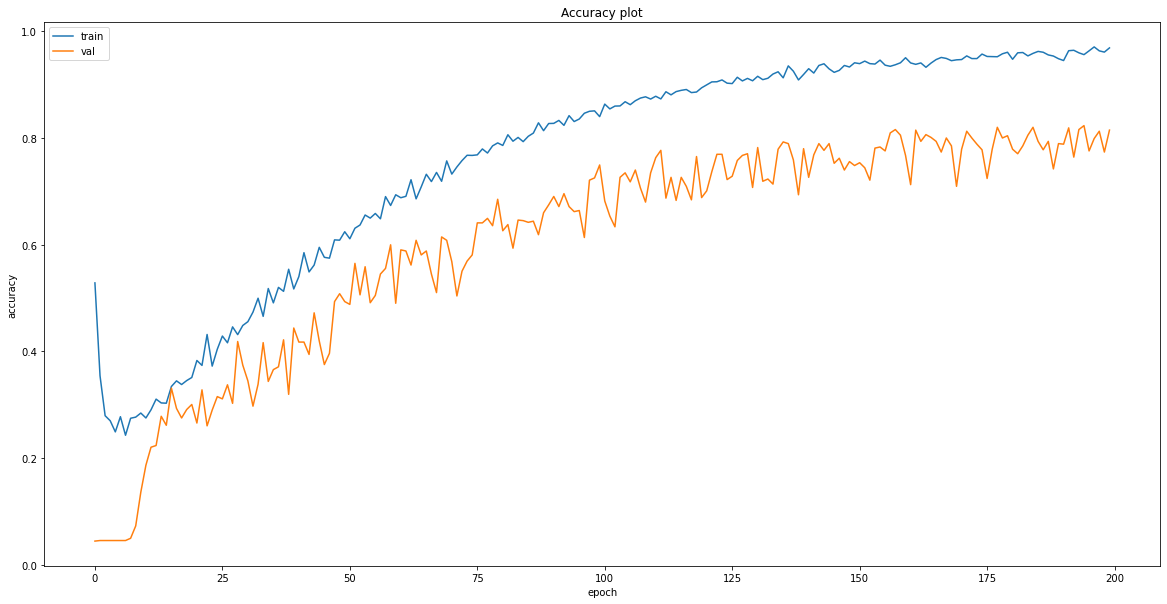

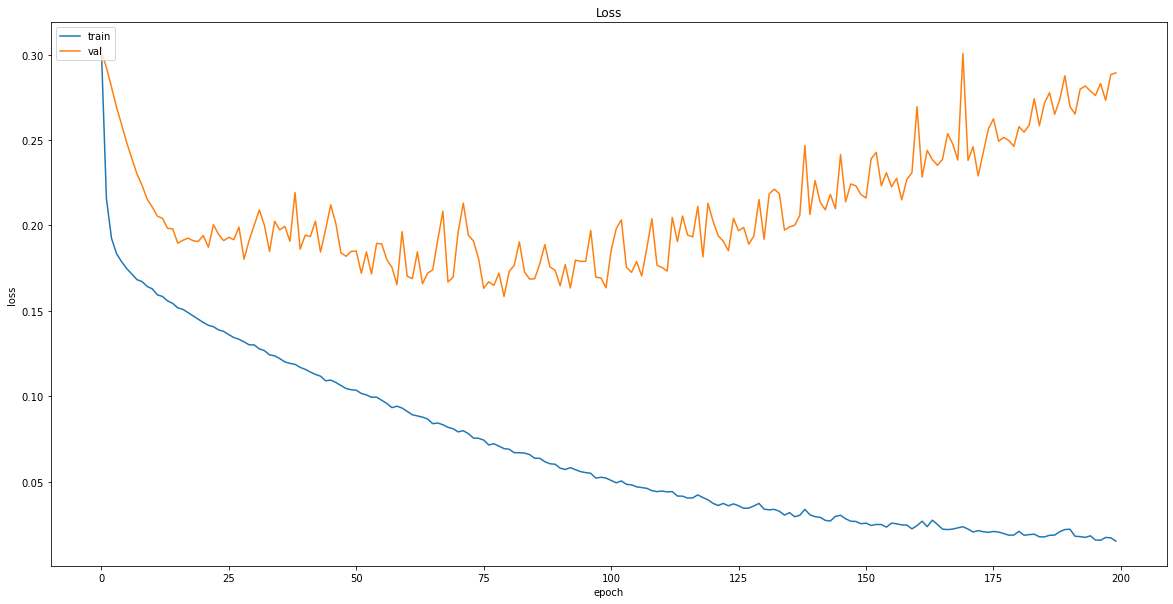

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('KR_support_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/KR_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [71]:
logger = []

In [72]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    29.430000  28.387007  -4.858258  41061300.0     2.0
2019-01-23    29.320000  28.530544  -9.311725  36484100.0     2.0
2019-01-24    29.240000  28.639691 -14.919380  31104500.0     2.0
2019-01-25    28.709999  28.650508 -38.135648  21525300.0     2.0
2019-01-28    28.120001  28.568891 -63.135567  13527400.0     2.0


In [73]:
df2 = pd.read_csv("data/variation 6/initial_indicators/WMT_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,97.730003,95.334462,-7.164539,58918700.0,2.0
2019-01-23,97.489998,95.666083,-13.843922,50855500.0,0.0
2019-01-24,98.709999,96.134378,-9.609606,59201300.0,2.0
2019-01-25,98.360001,96.476781,-14.864842,51591600.0,2.0
2019-01-28,96.940002,96.548046,-38.683751,44373400.0,2.0


In [74]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2019-01-22,29.430000,28.387007,-4.858258,41061300.0,97.730003,2.0
2019-01-23,29.320000,28.530544,-9.311725,36484100.0,97.489998,2.0
2019-01-24,29.240000,28.639691,-14.919380,31104500.0,98.709999,2.0
2019-01-25,28.709999,28.650508,-38.135648,21525300.0,98.360001,2.0
2019-01-28,28.120001,28.568891,-63.135567,13527400.0,96.940002,2.0


In [75]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [76]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(218, 15, 5)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/KR_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2405 - accuracy: 0.8578 - mean_squared_error: 14.4323 - weighted_accuracy: 0.8578 - weighted_mean_squared_error: 14.4323
Test loss: 0.24050644040107727
Test accuracy: 0.857798159122467


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 202, 1: 7, 0: 9})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 199, 0: 9})

In [81]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)

In [82]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,27.549999,28.220168,-89.447281,18063500.0,1.0,2,1
2019-02-12,28.580000,28.117065,-98.564652,13001800.0,2.0,1,2
2019-02-13,28.959999,28.188286,-45.077757,21452700.0,2.0,2,2
2019-02-14,28.959999,28.307011,-7.096817,27986100.0,2.0,2,2
2019-02-15,29.500000,28.407471,-25.388684,27986100.0,2.0,2,2


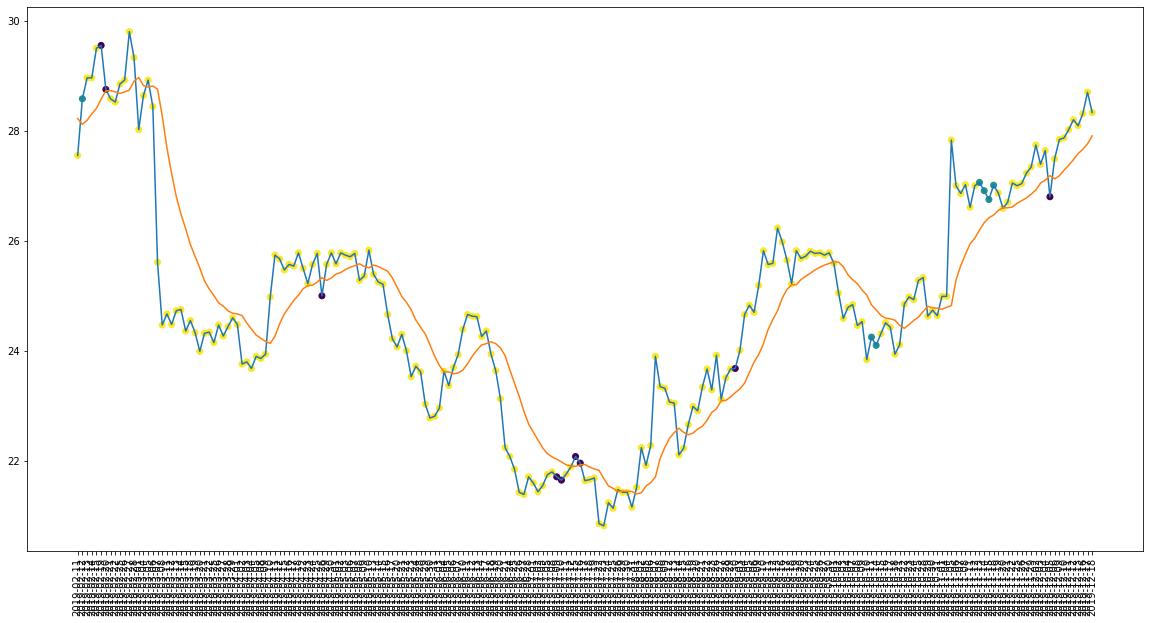

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

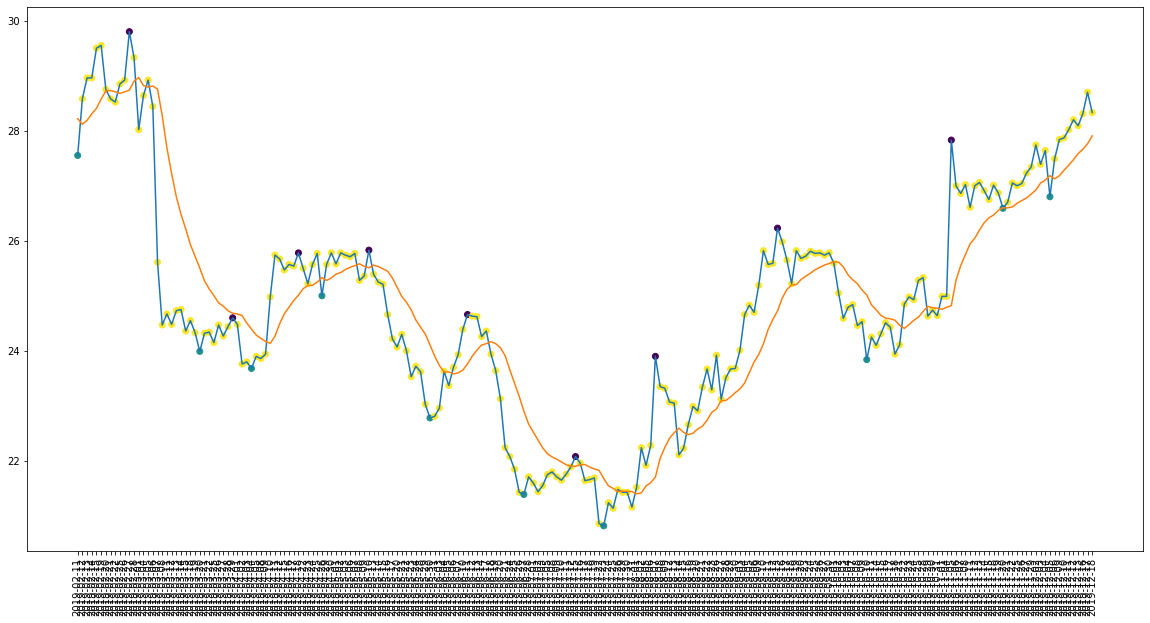

In [84]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 2
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 7
actual holds but predicted sell: 6
actual predicted holds: 186
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 93.46733668341709%
actual buys: 10
actual sells: 9
actual holds: 199


In [86]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[27.54999923706055, 28.520000457763672, 28.57999992370605, 28.57999992370605, 28.75, 28.959999084472656, 28.959999084472656, 29.5, 29.54999923706055]
[28.020000457763672, 28.520000457763672, 28.57999992370605, 28.63999938964844, 28.75, 28.85000038146973, 28.920000076293945, 29.32999992370605, 29.79999923706055]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 84.07960199004975%


In [87]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.57999992370605
Shares owned at the moment: 348
Cash capital at the moment: $26.80896662330815


Stop Loss Activated!

Share price: $25.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8914.580408441543


Share price: $24.25
Shares owned at the moment: 366
Cash capital at the moment: $14.672783441543288


Price increase from previously bought: 10.212376735361461%
Share price: $26.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9796.498304973604




Capital at the end of test period: $9796.498304973604
profit gained: -2.035016950263962%


In [88]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10226.105378712173
profit gained: 2.2610537871217273%


In [89]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,0.0%,11.11111111111111%,82.41206030150754%,38.095238095238095%,43.75%,82.32044198895028%,-16.087911087532067%,1.237104801502228%
1,0.789954,7.6923076923076925%,23.076923076923077%,87.56476683937824%,44.44444444444444%,60.0%,79.47368421052632%,-17.263616551914257%,9.08974277930256%
2,0.857798,0.0%,11.11111111111111%,93.46733668341709%,57.142857142857146%,33.333333333333336%,84.07960199004975%,-2.035016950263962%,2.2610537871217273%


### recession test data

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


In [92]:
df2 = pd.read_csv("data/variation 6/initial_indicators/WMT_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,115.589996,116.459043,-80.074504,-17684500.0,2.0
2020-01-23,116.099998,116.403805,-70.577262,-12758400.0,2.0
2020-01-24,115.809998,116.312450,-69.789236,-17063500.0,2.0
2020-01-27,114.370003,116.013612,-94.416205,-21446900.0,2.0
2020-01-28,115.860001,115.989979,-34.297465,-14428500.0,2.0


In [93]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2020-01-22,28.410000,28.475794,-65.217413,9500700.0,115.589996,2.0
2020-01-23,28.370001,28.459518,-68.695589,4678900.0,116.099998,2.0
2020-01-24,28.440001,28.456515,-52.222168,8638500.0,115.809998,2.0
2020-01-27,28.190001,28.415513,-79.999958,3996300.0,114.370003,2.0
2020-01-28,28.330000,28.402357,-50.434793,8238000.0,115.860001,2.0


In [94]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(219, 15, 5)

In [95]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [96]:
model = tf.keras.models.load_model("models/KR_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3102 - accuracy: 0.7991 - mean_squared_error: 15.8456 - weighted_accuracy: 0.7991 - weighted_mean_squared_error: 15.8456
Test loss: 0.3101810812950134
Test accuracy: 0.7990867495536804


In [97]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 199, 0: 7, 1: 13})

In [98]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [99]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)

In [100]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,28.440001,27.892005,-25.654440,10558800.0,2.0,2,2
2020-02-12,28.690001,27.976312,-9.473693,14655000.0,2.0,2,2
2020-02-13,28.629999,28.086110,-7.075451,19030600.0,2.0,2,2
2020-02-14,28.230000,28.169785,-9.905703,15348600.0,2.0,2,2
2020-02-18,29.709999,28.179049,-28.773602,10540700.0,2.0,2,2


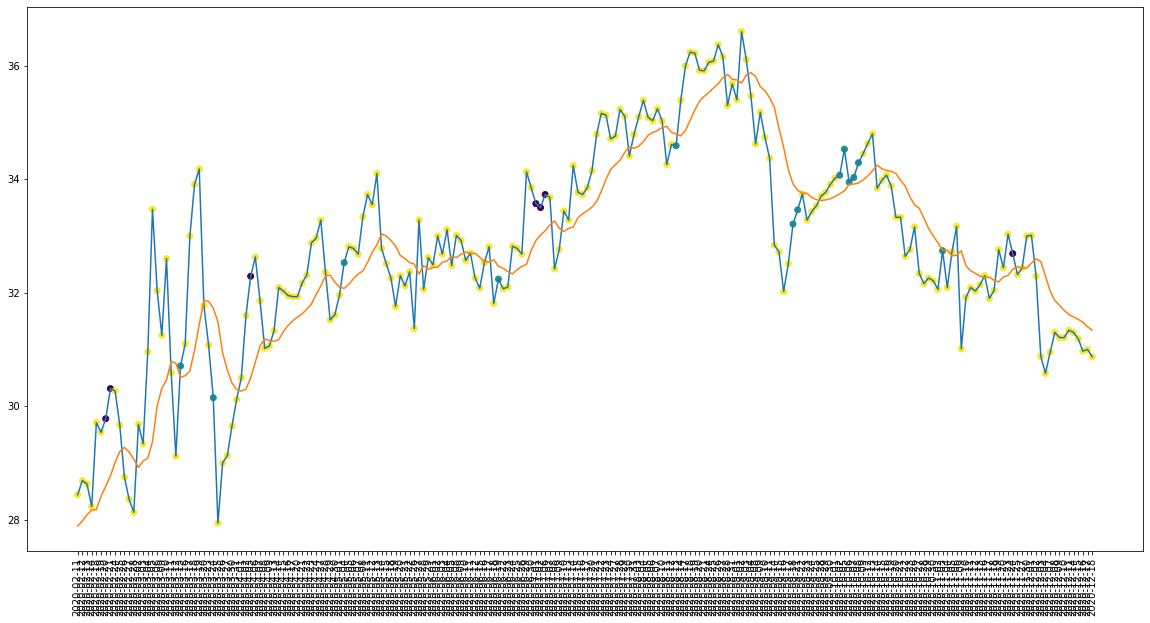

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

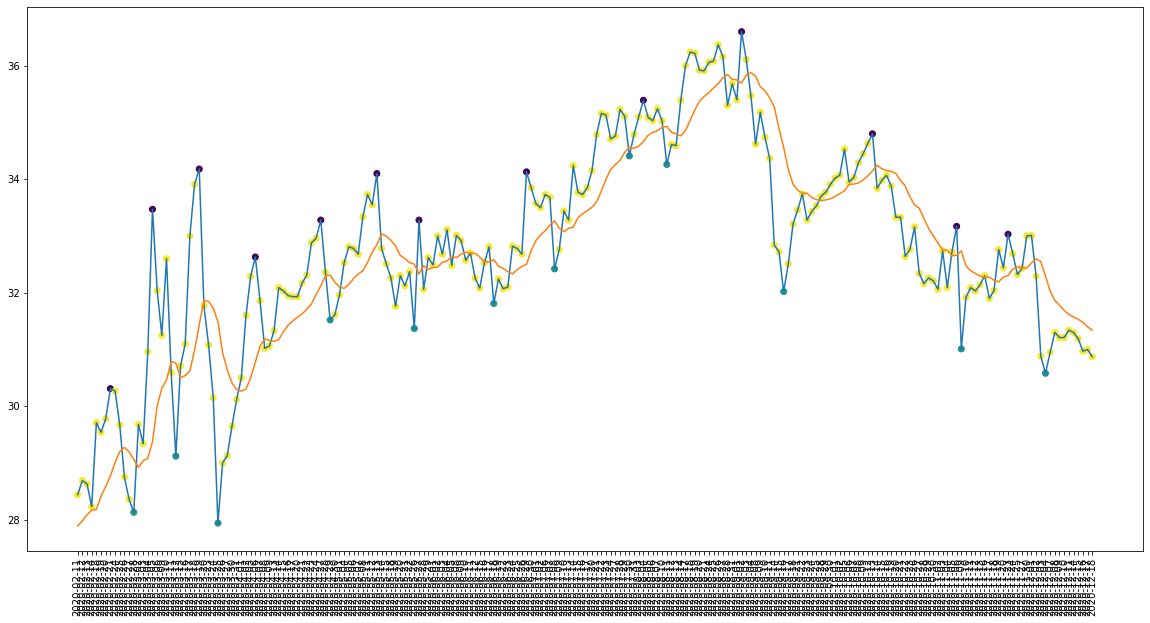

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 13
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 13
actual holds but predicted sell: 6
actual predicted holds: 174
Percentage buys correct: 0.0%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.15544041450777%
actual buys: 13
actual sells: 13
actual holds: 193


In [104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[28.229999542236328, 28.440000534057607, 28.6299991607666, 28.690000534057607, 29.540000915527344, 29.709999084472656, 29.78000068664551, 30.270000457763672, 30.309999465942386]
[28.1299991607666, 28.36000061035156, 28.75, 29.34000015258789, 29.670000076293945, 29.68000030517578, 29.78000068664551, 30.270000457763672, 30.309999465942386]
Percentage buys correct: 30.76923076923077%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 78.28282828282828%


In [105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.709999084472656
Shares owned at the moment: 324
Cash capital at the moment: $22.597687446594136


Stop Loss Activated!

Share price: $27.940000534057607
Shares owned at the moment: 0
Cash capital at the moment: $9050.263320005413


Share price: $32.529998779296875
Shares owned at the moment: 277
Cash capital at the moment: $14.673931570048808


Stop Loss Activated!

Share price: $31.3700008392334
Shares owned at the moment: 0
Cash capital at the moment: $8680.268065898414


Share price: $32.240001678466804
Shares owned at the moment: 268
Cash capital at the moment: $16.1867348322794


Stop Loss Activated!

Share price: $31.01000022888184
Shares owned at the moment: 0
Cash capital at the moment: $8304.012426003927




Capital at the end of test period: $8304.012426003927
profit gained: -16.959875739960733%


In [106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10793.414230489732
profit gained: 7.934142304897322%


In [107]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,0.0%,11.11111111111111%,82.41206030150754%,38.095238095238095%,43.75%,82.32044198895028%,-16.087911087532067%,1.237104801502228%
1,0.789954,7.6923076923076925%,23.076923076923077%,87.56476683937824%,44.44444444444444%,60.0%,79.47368421052632%,-17.263616551914257%,9.08974277930256%
2,0.857798,0.0%,11.11111111111111%,93.46733668341709%,57.142857142857146%,33.333333333333336%,84.07960199004975%,-2.035016950263962%,2.2610537871217273%
3,0.799087,0.0%,7.6923076923076925%,90.15544041450777%,30.76923076923077%,57.142857142857146%,78.28282828282828%,-16.959875739960733%,7.934142304897322%


In [108]:
experiment

'KR Variation 6 LSTM Time Series'

In [109]:
log.to_csv('{}.csv'.format(experiment))